<h1>Содержание<span class="tocSkip"></span></h1>
<div class="toc"><ul class="toc-item"><li><span><a href="#Подготовка" data-toc-modified-id="Подготовка-1"><span class="toc-item-num">1&nbsp;&nbsp;</span>Подготовка</a></span></li><li><span><a href="#Обучение" data-toc-modified-id="Обучение-2"><span class="toc-item-num">2&nbsp;&nbsp;</span>Обучение</a></span></li><li><span><a href="#Выводы" data-toc-modified-id="Выводы-3"><span class="toc-item-num">3&nbsp;&nbsp;</span>Выводы</a></span></li><li><span><a href="#Чек-лист-проверки" data-toc-modified-id="Чек-лист-проверки-4"><span class="toc-item-num">4&nbsp;&nbsp;</span>Чек-лист проверки</a></span></li></ul></div>

# Проект для «Викишоп»

Интернет-магазин «Викишоп» запускает новый сервис. Теперь пользователи могут редактировать и дополнять описания товаров, как в вики-сообществах. То есть клиенты предлагают свои правки и комментируют изменения других. Магазину нужен инструмент, который будет искать токсичные комментарии и отправлять их на модерацию. 

Обучите модель классифицировать комментарии на позитивные и негативные. В вашем распоряжении набор данных с разметкой о токсичности правок.

С целью уменьшения времени обучения в качестве модели использовать Логистическую регрессию. Постройте модель со значением метрики качества *F1* не меньше 0.75. 

## Подготовка

In [1]:
import warnings
warnings.filterwarnings('ignore')

import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import nltk
from nltk.corpus import stopwords as nltk_stopwords
from nltk.stem import WordNetLemmatizer
import re


from sklearn.linear_model import LogisticRegression
from sklearn.metrics import f1_score
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import Pipeline

In [2]:
df = pd.read_csv('datasets/toxic_comments.csv')
df.info()
df.head()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 159571 entries, 0 to 159570
Data columns (total 2 columns):
 #   Column  Non-Null Count   Dtype 
---  ------  --------------   ----- 
 0   text    159571 non-null  object
 1   toxic   159571 non-null  int64 
dtypes: int64(1), object(1)
memory usage: 2.4+ MB


,text,toxic
0,Explanation\nWhy the edits made under my usern...,0
1,D'aww! He matches this background colour I'm s...,0
2,"Hey man, I'm really not trying to edit war. It...",0
3,"""\nMore\nI can't make any real suggestions on ...",0
4,"You, sir, are my hero. Any chance you remember...",0


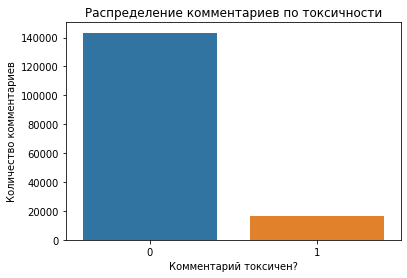

In [3]:
sns.countplot(x="toxic", data=df)
plt.title('Распределение комментариев по токсичности')
plt.ylabel('Количество комментариев')
plt.xlabel('Комментарий токсичен?')
plt.show()

<b> Вывод:</b>
* Данные загружены, пропущенных данных нет. 
* Предобработка не требуется. 
* Негативных комментариев в данном датасете в 7 раз меньше ,чем позитивных. При построение линейных моделей будем учитывать этот факт балансируя классами с помощью параметра class_weight

## Обучение

In [4]:
nltk.download('stopwords')
nltk.download('wordnet')
nltk.download('punkt')
stopwords = set(nltk_stopwords.words('english'))
lemmatizer = WordNetLemmatizer()

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\Влад\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\Влад\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\Влад\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [5]:
def clear_text(text):
    x = re.sub('\W+',' ',text)
    return ' '.join(x.split()).lower()


def lemmer(text):
    word_list = nltk.word_tokenize(text)
    stem_text = ' '.join([lemmatizer.lemmatize(w) for w in word_list])
    return stem_text

In [6]:
df['clear_text'] = df['text'].apply(lambda x: clear_text(x))
df['lemm_text'] = df['clear_text'].apply(lambda x: lemmer(x))

In [7]:
df.head()

,text,toxic,clear_text,lemm_text
0,Explanation\nWhy the edits made under my usern...,0,explanation why the edits made under my userna...,explanation why the edits made under my userna...
1,D'aww! He matches this background colour I'm s...,0,d aww he matches this background colour i m se...,d aww he match this background colour i m seem...
2,"Hey man, I'm really not trying to edit war. It...",0,hey man i m really not trying to edit war it s...,hey man i m really not trying to edit war it s...
3,"""\nMore\nI can't make any real suggestions on ...",0,more i can t make any real suggestions on impr...,more i can t make any real suggestion on impro...
4,"You, sir, are my hero. Any chance you remember...",0,you sir are my hero any chance you remember wh...,you sir are my hero any chance you remember wh...


Была проведена чистка текста не подходящих по шаблону слов, затем проведена лемматизация. В результате добавлены столбцы в базу данных clear_text, lemm_text.

In [8]:
train, test = train_test_split(df, test_size=0.2)

Данные поделены на обучающую и тестовую выборку в соотношении 4:1.

In [9]:
corpus_train = train['lemm_text'].values.astype('U')
count_tf_idf= TfidfVectorizer(stop_words=stopwords)
tf_idf_train = count_tf_idf.fit_transform(corpus_train)

corpus_test = test['lemm_text'].values.astype('U')
tf_idf_test = count_tf_idf.transform(corpus_test)

Получены значения TF-IDF для тестовой и обучающей выборки.

In [10]:
pipe = Pipeline([
    (
    ('model', LogisticRegression(random_state=123456, solver='liblinear', max_iter=100))
    )
])

param_grid = [
        {
            'model': [LogisticRegression(random_state=123456, solver='liblinear')],
            'model__penalty' : ['l1', 'l2'],
            'model__C': list(range(1,15,3))
        }
]

# Прогоняем модель через GridSearchCV для нахождения лучших параметров.
grid = GridSearchCV(pipe, param_grid=param_grid, scoring='f1', cv=5, verbose=True)
grid.fit(tf_idf_train, train['toxic'])
grid.best_params_
print('Best score is:', grid.best_score_)

Fitting 5 folds for each of 10 candidates, totalling 50 fits
Best score is: 0.7720903317440395


Подобраны параметры кросс-валидацией для модели Логистической регресии. Наилучшее значение метрики F1 равно 0,77.

In [11]:
model = LogisticRegression(class_weight='balanced', random_state=123456, solver='liblinear', C=4, penalty='l1')
model.fit(tf_idf_train, train['toxic'])
pred = pd.Series(model.predict(tf_idf_test))
F1= f1_score(test['toxic'], pred)
print('F1-мера для Логистической регрессии {:.1%}'.format(F1))

F1-мера для Логистической регрессии 76.6%


При тестировании модели произошло незначительное снижение метрики.

###### <b>Вывод:</b> 
* Данные загружены, пропущенных данных нет. Предобработка не требуется. 
* Негативных комментариев в данном датасете в 7 раз меньше ,чем позитивных. При построение линейных моделей будем учитывать этот факт балансируя классами с помощью параметра class_weight.
* Из текстов были составлены корпуса текста. Были вычислены TFIDF, которые при обучении модели испольщовались как признаки.
* В результате подбора параметров кросс-валидацией при тестировании Логистическая модель показала значение метрики F1 равной 0,766. 